# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

# Final Report

https://docs.google.com/document/d/1llawB1bKJ_XZlNxpL1k80gF_2ozV4pCX03W2XS_xPDU/edit?usp=sharing

# 1, Utility Functions for processing the data

In [6]:
# Load, show, and save images with OpenCV

from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

In [7]:
# Define the DataLoader

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)

In [8]:
# Evaluation for the model's accuracy

def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

# 2, Model Definement

In [9]:
# Define the segmentation model, here we adopt FCN (Fully Convolutional Network)

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
from torch import optim

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')


def bilinear_kernel(in_channels, out_channels, kernel_size):
    #Define a bilinear kernel according to in channels and out channels.
    #Returns:
    #    return a bilinear filter tensor
    
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    bilinear_filter = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float32)
    weight[range(in_channels), range(out_channels), :, :] = bilinear_filter
    
    return torch.from_numpy(weight)


pretrained_net = models.vgg16_bn(pretrained=False)

pretrained_net.features[0] = nn.Conv2d(1,
                                       4,
                                       kernel_size=(3, 3),
                                       stride=(1, 1),
                                       padding=(1, 1))
pretrained_net.features[1] = nn.BatchNorm2d(4,
                                            eps=1e-05,
                                            momentum=0.1,
                                            affine=True,
                                            track_running_stats=True)
pretrained_net.features[2] = nn.ReLU(inplace=True)
pretrained_net.features[3] = nn.Conv2d(4,
                                       64,
                                       kernel_size=(3, 3),
                                       stride=(1, 1),
                                       padding=(1, 1))
pretrained_net.features[4] = nn.BatchNorm2d(64,
                                            eps=1e-05,
                                            momentum=0.1,
                                            affine=True,
                                            track_running_stats=True)
pretrained_net.features[5] = nn.ReLU(inplace=True)
pretrained_net.features[6] = nn.MaxPool2d(kernel_size=2,
                                          stride=2,
                                          padding=0,
                                          dilation=1,
                                          ceil_mode=False)

class CNNSEG(nn.Module): # Define your model
    def __init__(self):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here
        self.stage1 = pretrained_net.features[:7]
        self.stage2 = pretrained_net.features[7:14]
        self.stage3 = pretrained_net.features[14:24]
        self.stage4 = pretrained_net.features[24:34]
        self.stage5 = pretrained_net.features[34:]

        self.scores1 = nn.Conv2d(512, 4, 1)
        self.scores2 = nn.Conv2d(512, 4, 1)
        self.scores3 = nn.Conv2d(128, 4, 1)

        self.conv_trans1 = nn.Conv2d(512, 256, 1)
        self.conv_trans2 = nn.Conv2d(256, 4, 1)

        self.upsample_8x = nn.ConvTranspose2d(4, 4, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(4, 4, 16)

        self.upsample_2x_1 = nn.ConvTranspose2d(512, 512, 4, 2, 1, bias=False)
        self.upsample_2x_1.weight.data = bilinear_kernel(512, 512, 4)

        self.upsample_2x_2 = nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False)
        self.upsample_2x_2.weight.data = bilinear_kernel(256, 256, 4)
        
    def forward(self, x):
        # split the pre-trained VGG16bn into 5 stages
        # In each stage: we contain two or three convolution layers, and end with the maxpooling layer
        # The detailed layer information for each stages are shown in the following cells
        s1 = self.stage1(x)
        s1 = nn.Dropout2d(p=0.1).forward(s1)
        s2 = self.stage2(s1)
        s2 = nn.Dropout2d(p=0.1).forward(s2)
        s3 = self.stage3(s2)
        s3 = nn.Dropout2d(p=0.1).forward(s3)
        s4 = self.stage4(s3)
        s4 = nn.Dropout2d(p=0.1).forward(s4)
        s5 = self.stage5(s4)
        s5 = nn.Dropout2d(p=0.1).forward(s5)

        scores1 = self.scores1(s5) # output the FCN-32s
        
        s5 = self.upsample_2x_1(s5)
        add1 = s5 + s4
        scores2 = self.scores2(add1) # Output the FCN-16s

        add1 = self.conv_trans1(add1)
        add1 = self.upsample_2x_2(add1)
        add2 = add1 + s3

        output = self.conv_trans2(add2)
        output = self.upsample_8x(output)

        score3 = output # Output the FCN-8s

        return output

fcn = CNNSEG() # We can now create a model using your defined segmentation model
fcn = fcn.to(device)

In [10]:
print(pretrained_net.features[:7]) # Stage 1

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [11]:
print(pretrained_net.features[7:14]) # Stage 2

Sequential(
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [12]:
print(pretrained_net.features[14:24]) # Stage 3

Sequential(
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU(inplace=True)
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (19): ReLU(inplace=True)
  (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (22): ReLU(inplace=True)
  (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [13]:
print(pretrained_net.features[24:34]) # Stage 4

Sequential(
  (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (26): ReLU(inplace=True)
  (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (29): ReLU(inplace=True)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (32): ReLU(inplace=True)
  (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [14]:
print(pretrained_net.features[34:]) # Stage 5

Sequential(
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (36): ReLU(inplace=True)
  (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (39): ReLU(inplace=True)
  (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace=True)
  (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [15]:
print(models.vgg16_bn(pretrained=False))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
print(pretrained_net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, k

# 3, Train, Validation process and Test generation

# 3.1: Train

In [17]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image

data_train_path = './data/train'
data_val_path = './data/val'

"""
Change the hyper-parameter settings here
"""
num_workers = 0 # Threads used
batch_size = 10
epoches = 20 # 100 for training, and 20 for fine-tuning
learning_rate = 5e-4
weight_decay = 0.001


train_set = TrainDataset(data_train_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

conv_initial = nn.Conv2d(1, 3, 1)
conv_initial_mask = nn.Conv2d(1, 4, 1)

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [19]:
# Use Cross Entropy as the loss function, and Adam as optimizer

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [34]:
# define the train method

"""
parameters:
load_pretrained: whether the model is trained from scratch, or continue with the checkpoint
pretrained: (if load_pretrained is true,) the path for checkpoint file
"""
def train(model, load_pretrained=False, pretrained=None):

    net = model.train()
    
    if load_pretrained:
        net.load_state_dict(t.load(pretrained ,map_location=device))
        
    print(device)
    for epoch in range(epoches):
        print('Epoch is [{}/{}]'.format(epoch + 1, epoches))
#         if epoch % 50 == 0 and epoch != 0:
#             for group in optimizer.param_groups:
#                 group['lr'] *= 0.5

        # Initialize the loss and accuracy here
        train_loss = 0
        accuracy = 0
        count = 0
        
        for iteration, sample in enumerate(training_data_loader):
            img, mask = sample

            img = Variable(img.unsqueeze(1).to(device))
            mask = Variable(mask.to(device))

            pred_mask = net(img)
            pred_mask = F.log_softmax(pred_mask, dim=1)
            mask = mask.to(device=device, dtype=torch.int64)

            loss = criterion(pred_mask, mask)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            mask_image = torch.argmax(pred_mask.squeeze(), dim=1)
            mask_acc = mask.squeeze().unsqueeze(2).numpy()
            mask_image_acc = mask_image.unsqueeze(2).numpy()
            
            
#             if mask_acc.shape == (batch_size, 96, 1, 96) and mask_image_acc.shape == (batch_size, 96, 1, 96):
#             if mask_acc.shape == (batch_size, 96, 1, 96) and mask_image_acc.shape == (batch_size, 96, 1, 96):
            accuracy += categorical_dice(mask_acc, mask_image_acc)
            count = count + 1

            if iteration==0:
                mask_image_1=mask_image

        correct_mask = cv2.imread(os.path.join(data_train_path,'mask','cmr'+str(1)+'_mask.png'), cv2.IMREAD_UNCHANGED)
        show_image_mask(correct_mask, mask_image_1[0,...], cmap='gray')
        print('|batch[{}/{}]|train_batch_loss {: .8f}|'.format(epoch+1, epoches, train_loss/len(training_data_loader)))
        print('accuracy: {: .8f}'.format(accuracy/count))
    
    t.save(net.state_dict(), '{}.pth'.format('exp'))
    

cpu
Epoch is [1/20]
|batch[1/20]|train_batch_loss  0.03063421|
accuracy:  0.95310681
Epoch is [2/20]
|batch[2/20]|train_batch_loss  0.03275219|
accuracy:  0.95168448
Epoch is [3/20]
|batch[3/20]|train_batch_loss  0.03353032|
accuracy:  0.94974582
Epoch is [4/20]
|batch[4/20]|train_batch_loss  0.03439633|
accuracy:  0.94737221
Epoch is [5/20]
|batch[5/20]|train_batch_loss  0.03372583|
accuracy:  0.95052574
Epoch is [6/20]
|batch[6/20]|train_batch_loss  0.03669536|
accuracy:  0.95067845
Epoch is [7/20]
|batch[7/20]|train_batch_loss  0.03743890|
accuracy:  0.94181513
Epoch is [8/20]
|batch[8/20]|train_batch_loss  0.03743532|
accuracy:  0.94844842
Epoch is [9/20]
|batch[9/20]|train_batch_loss  0.03500102|
accuracy:  0.94965611
Epoch is [10/20]
|batch[10/20]|train_batch_loss  0.03511812|
accuracy:  0.94701950
Epoch is [11/20]
|batch[11/20]|train_batch_loss  0.03486835|
accuracy:  0.95011496
Epoch is [12/20]
|batch[12/20]|train_batch_loss  0.03511932|
accuracy:  0.94473308
Epoch is [13/20]
|

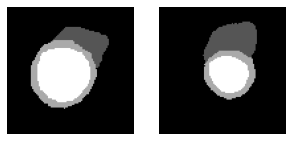

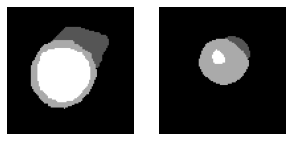

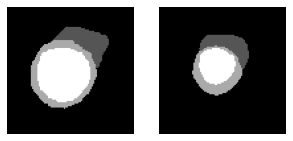

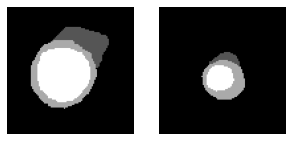

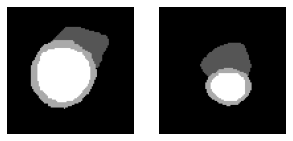

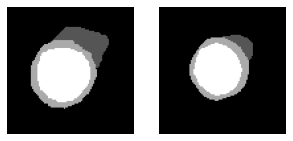

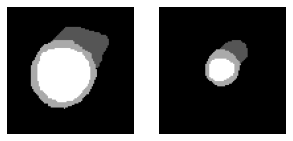

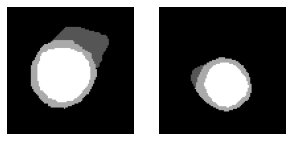

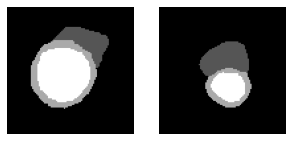

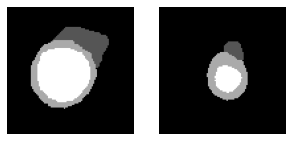

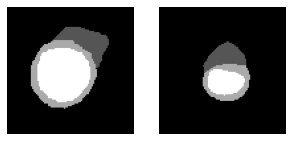

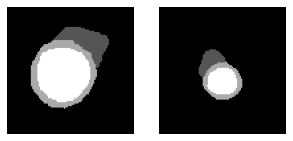

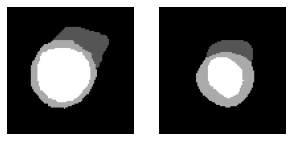

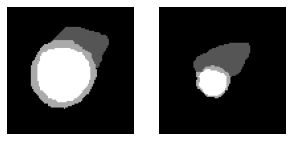

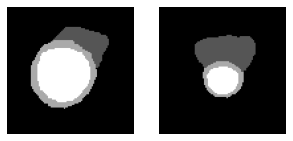

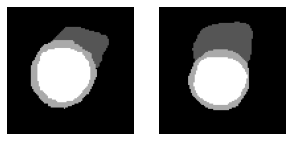

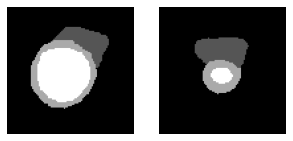

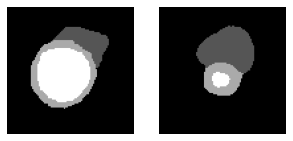

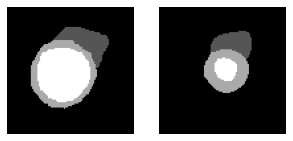

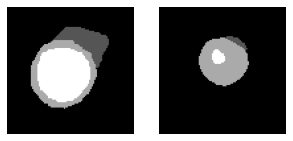

In [35]:
if __name__ == "__main__":
#      train(fcn, True, 'checkpoint.pth')
    train(fcn, True, 'exp.pth')

# 3.2:  Validation

In [36]:
# define the validation method

"""
parameters:
pretrained: the path for checkpoint file
"""

val_set = TrainDataset(data_val_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=2, shuffle=True)


def validate(model, pretrained=None):
    net = model.eval()
    net.load_state_dict(t.load('{}.pth'.format(pretrained),map_location=device))
    print('{}.pth'.format(pretrained))
    
    # Initialize the loss and accuracy for the model
    val_loss = 0
    accuracy = 0
    batch_size=2
    count = 0
    index = 0
    
    
    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample
        img = img.unsqueeze(1).to(device)
        mask = mask.to(device)
        
        pred_mask = net(img)
#         pred_mask = F.log_softmax(pred_mask, dim=1)
        mask = mask.to(device=device, dtype=torch.int64)

        loss = criterion(pred_mask, mask)

        val_loss += loss.item()
        mask_image = torch.argmax(pred_mask.squeeze(), dim=1)
        
        for i in range(batch_size):
            image = cv2.imread(os.path.join(data_val_path,'image','cmr'+str(index+101+i)+'.png'), cv2.IMREAD_UNCHANGED)
            correct_mask = cv2.imread(os.path.join(data_val_path,'mask','cmr'+str(index+101+i)+'_mask.png'), cv2.IMREAD_UNCHANGED)
            accuracy += categorical_dice(mask[i].numpy(), mask_image[i].detach().numpy())
            count = count + 1
        
            
        index += batch_size
        
#         mask_acc = mask.squeeze().unsqueeze(2).numpy()
#         mask_image_acc = mask_image.unsqueeze(2).numpy()

#         if mask_acc.shape == (batch_size, 96, 1, 96) and mask_image_acc.shape == (batch_size, 96, 1, 96):
        
        show_image_mask(correct_mask, mask_image[i,...], cmap='gray')
        if iteration==0:
            mask_image_1=mask_image
    
    print("Val_loss is " + str(val_loss/len(val_data_loader)))
    print('accuracy: {: .8f}'.format(accuracy/count))
    

exp.pth
Val_loss is 0.10606038197875023
accuracy:  0.74098582
exp.pth
Val_loss is 0.09863784834742546
accuracy:  0.75889539
exp.pth


<ipython-input-6-57e2c465ffdf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5,5))


Val_loss is 0.10056658275425434
accuracy:  0.74810380
exp.pth
Val_loss is 0.1003621019423008
accuracy:  0.73623919
exp.pth
Val_loss is 0.10020747482776642
accuracy:  0.75146053
exp.pth
Val_loss is 0.09821762852370738
accuracy:  0.74217917
exp.pth
Val_loss is 0.09889733642339707
accuracy:  0.75468295
exp.pth
Val_loss is 0.10089204758405686
accuracy:  0.74580687
exp.pth
Val_loss is 0.10216252133250237
accuracy:  0.74180930
exp.pth
Val_loss is 0.10149446427822113
accuracy:  0.74298112
exp.pth
Val_loss is 0.0996586125344038
accuracy:  0.75592471
exp.pth
Val_loss is 0.10659069120883942
accuracy:  0.74197679
exp.pth
Val_loss is 0.10414853543043137
accuracy:  0.73986054
exp.pth
Val_loss is 0.10014787688851357
accuracy:  0.75762345
exp.pth
Val_loss is 0.09738757275044918
accuracy:  0.76553038
exp.pth
Val_loss is 0.09985905326902866
accuracy:  0.74318772
exp.pth
Val_loss is 0.10147961676120758
accuracy:  0.73654183
exp.pth
Val_loss is 0.09883852452039718
accuracy:  0.74910258
exp.pth
Val_loss i

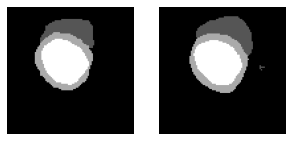

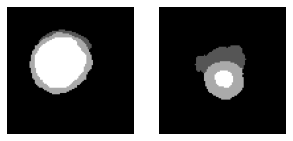

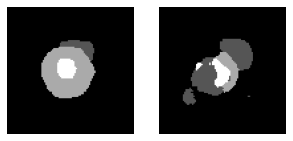

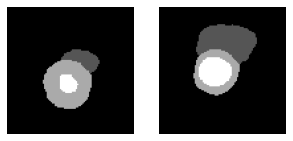

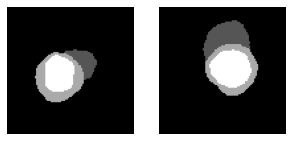

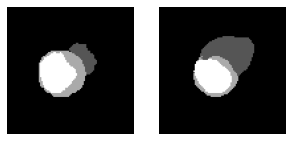

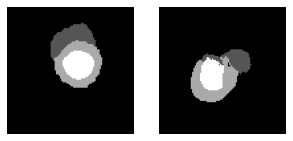

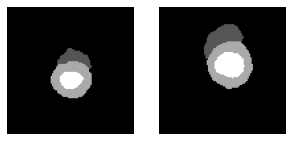

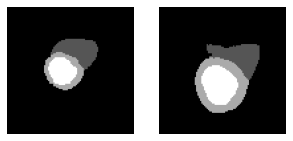

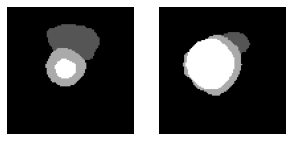

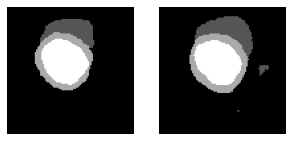

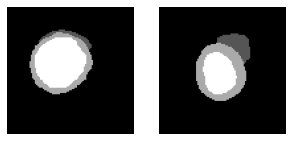

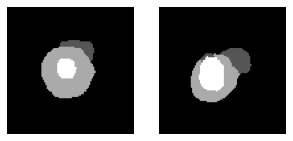

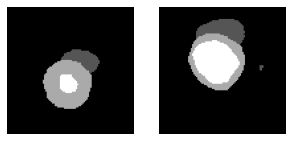

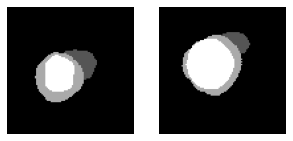

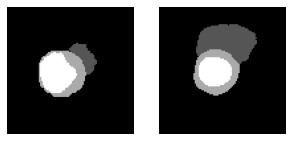

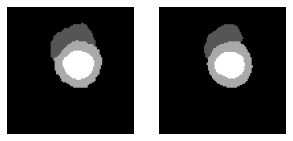

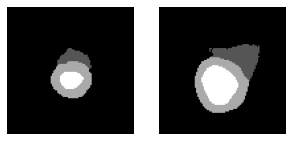

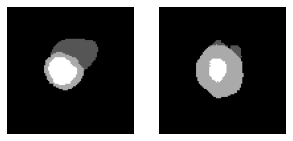

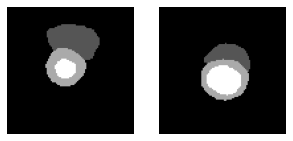

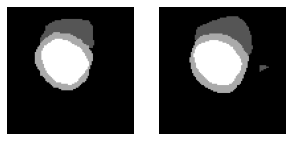

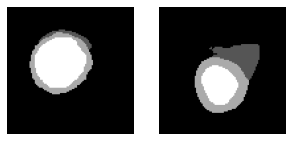

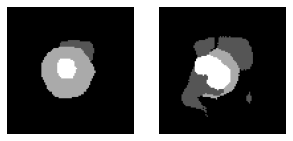

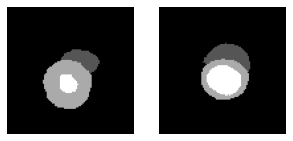

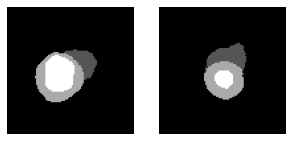

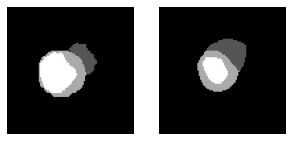

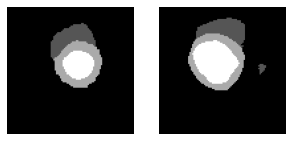

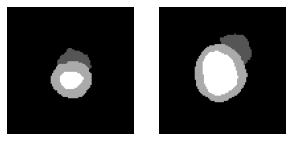

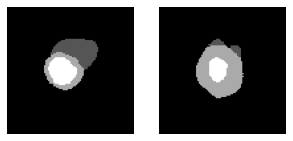

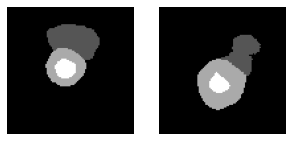

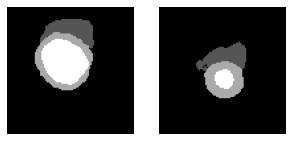

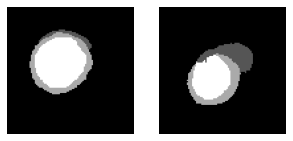

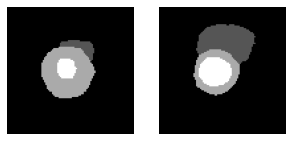

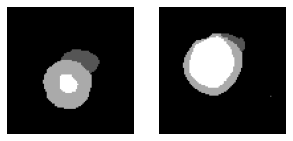

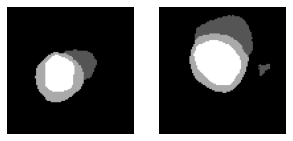

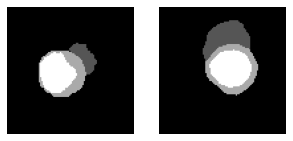

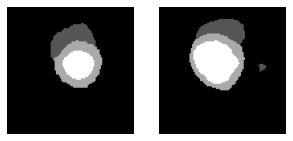

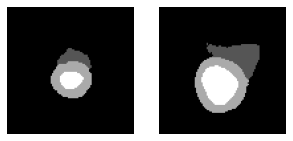

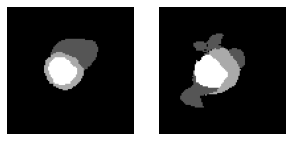

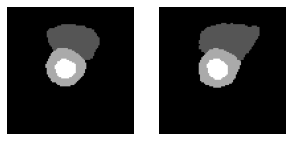

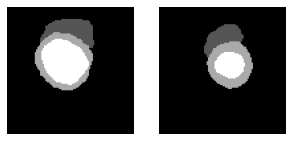

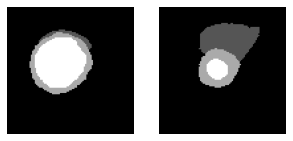

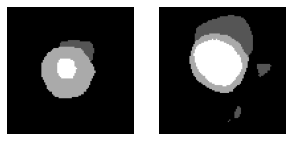

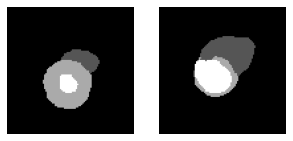

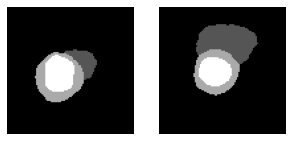

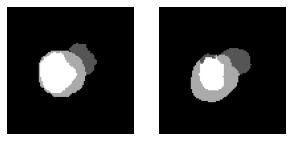

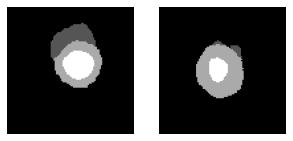

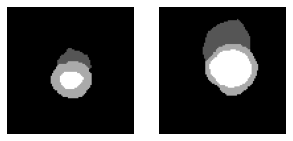

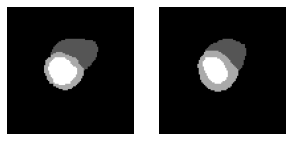

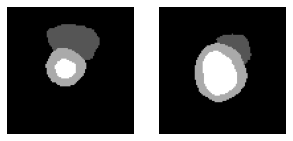

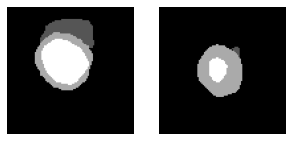

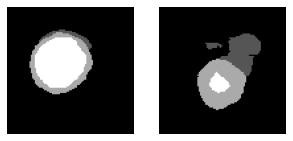

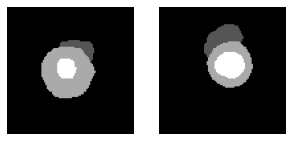

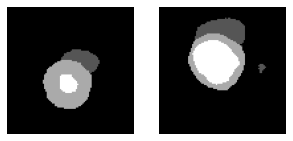

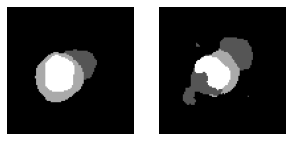

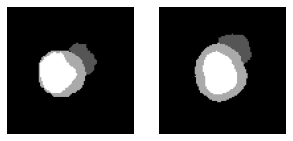

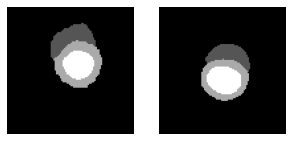

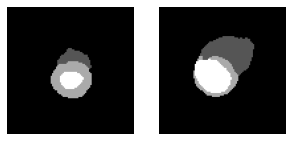

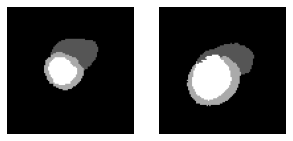

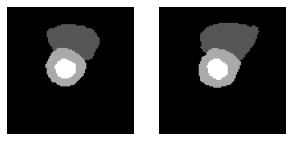

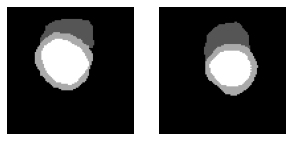

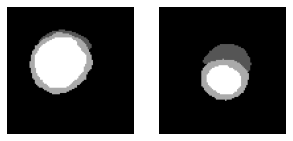

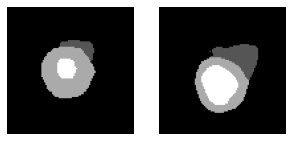

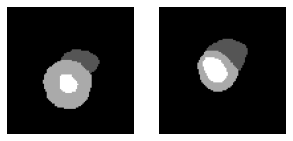

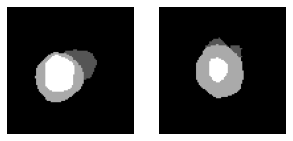

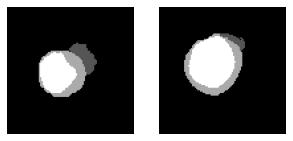

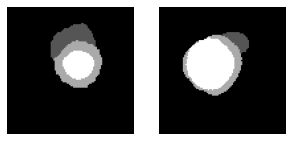

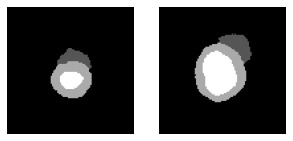

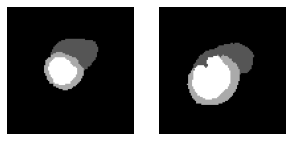

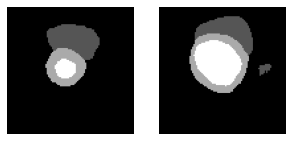

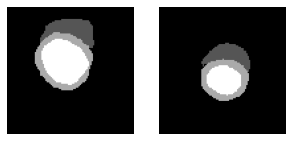

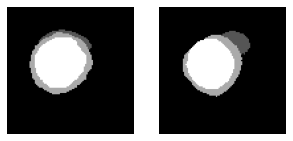

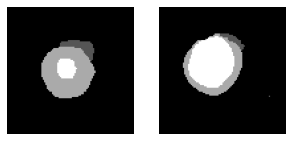

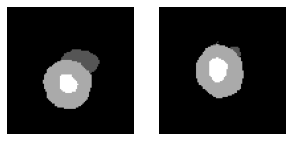

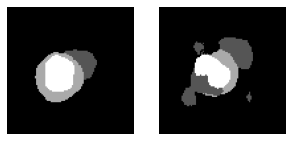

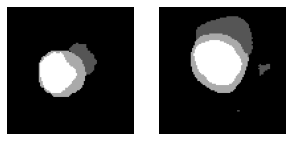

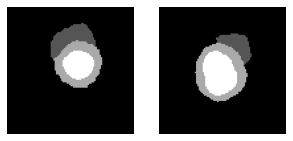

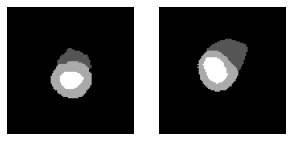

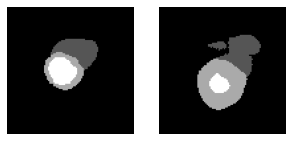

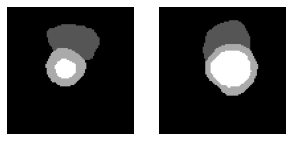

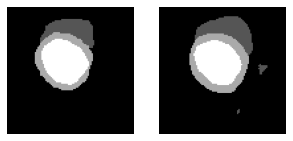

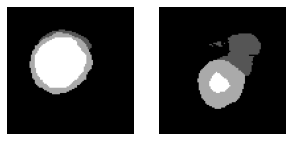

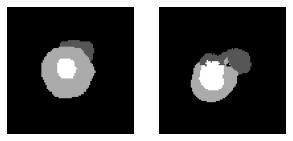

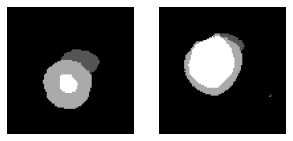

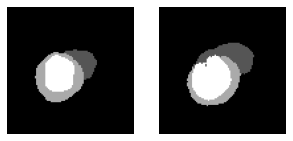

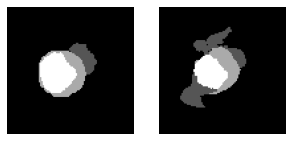

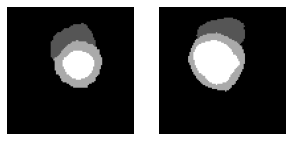

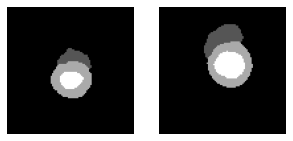

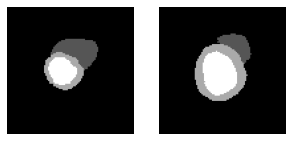

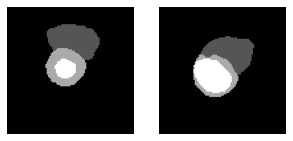

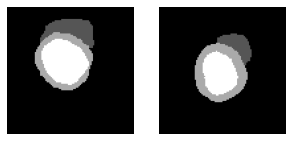

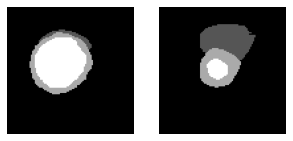

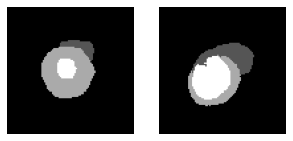

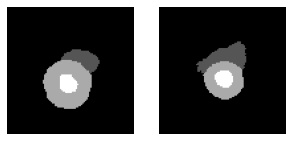

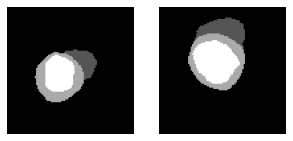

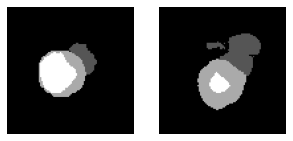

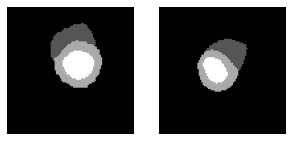

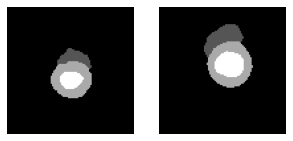

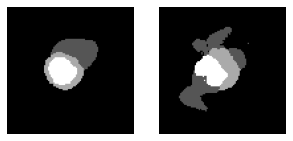

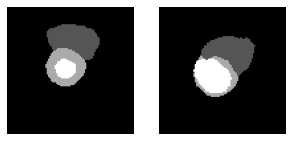

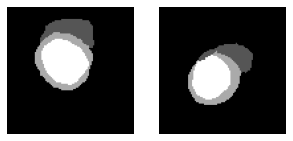

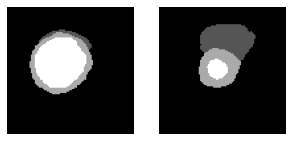

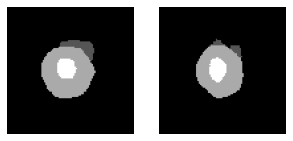

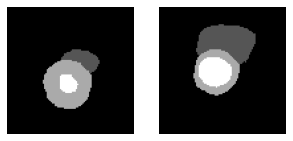

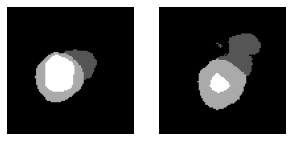

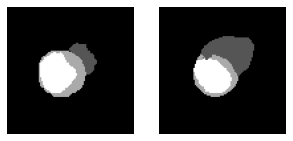

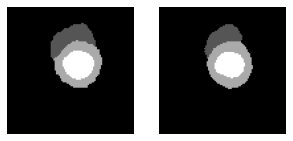

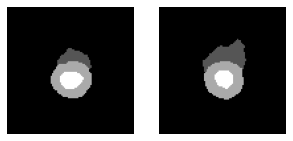

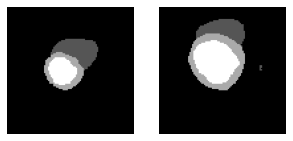

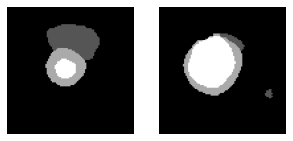

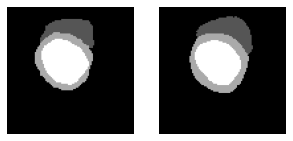

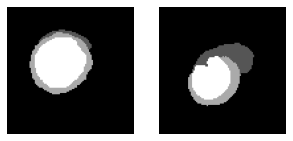

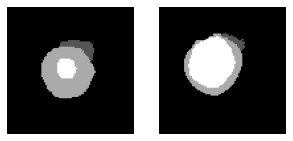

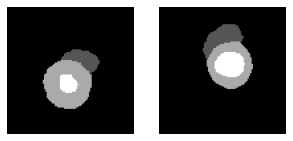

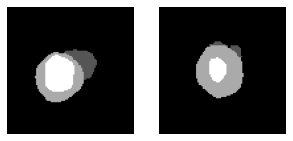

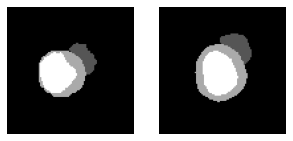

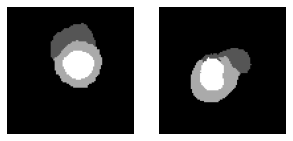

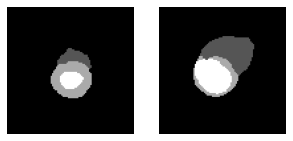

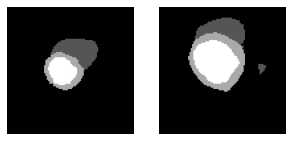

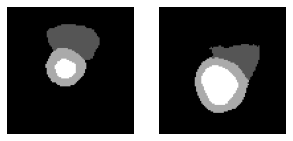

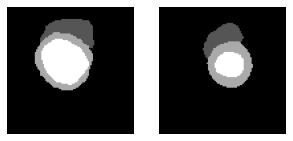

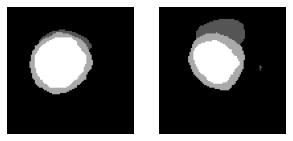

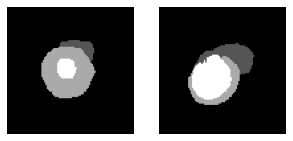

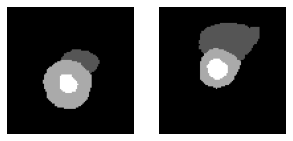

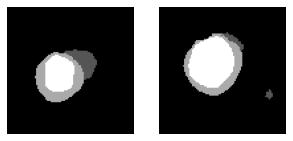

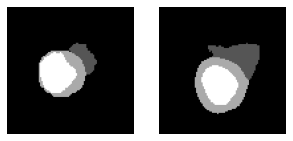

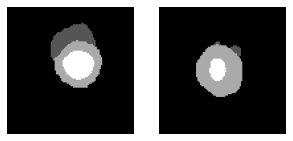

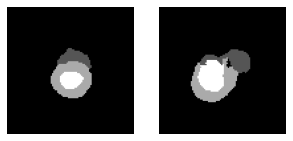

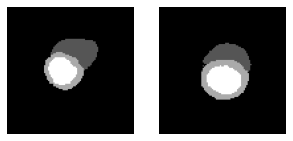

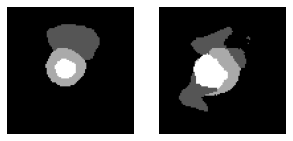

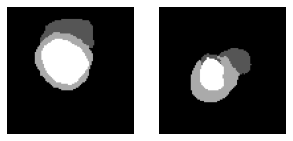

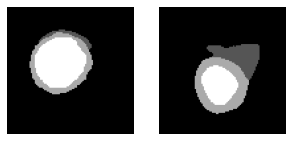

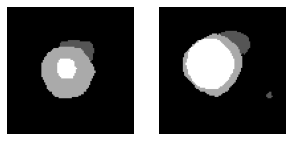

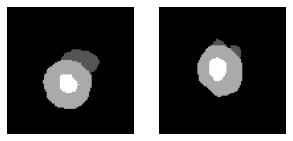

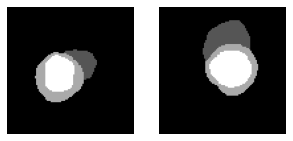

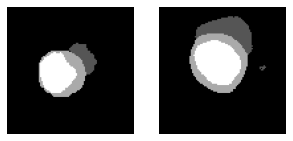

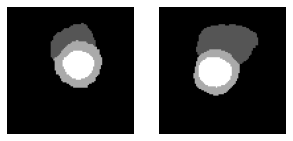

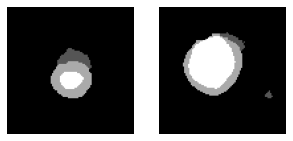

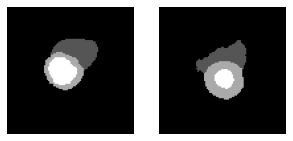

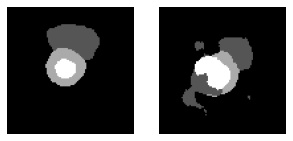

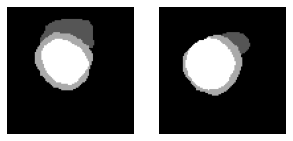

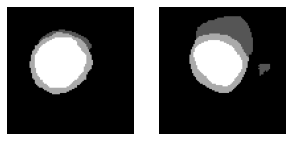

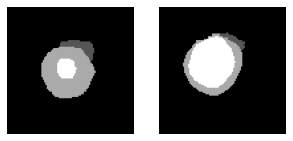

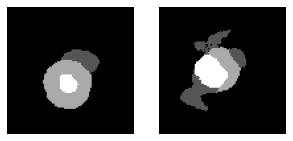

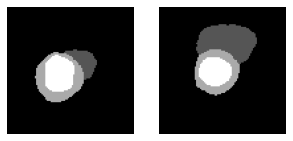

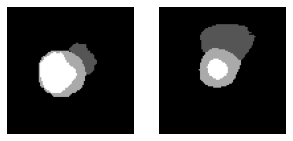

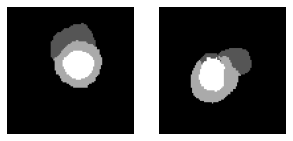

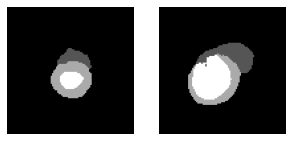

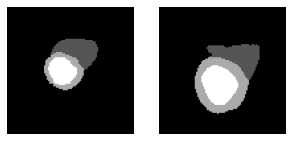

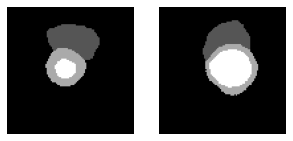

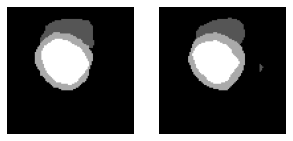

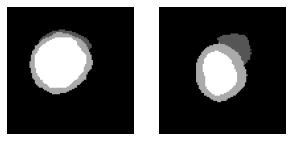

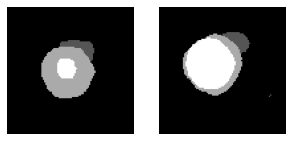

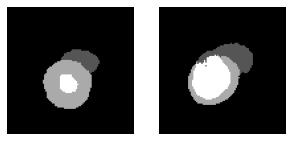

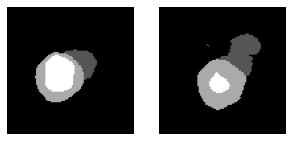

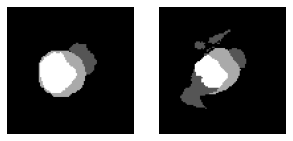

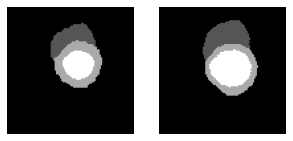

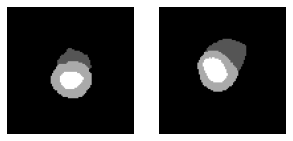

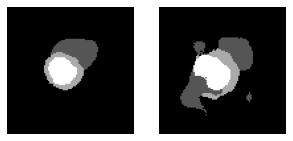

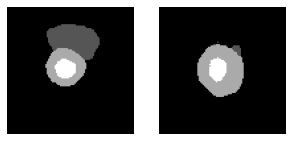

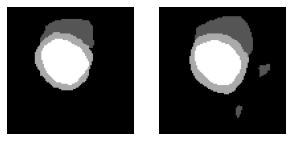

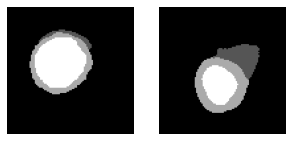

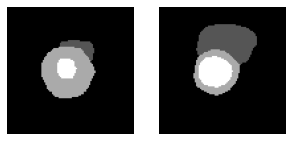

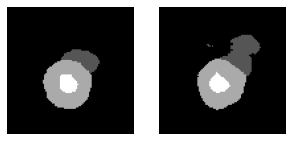

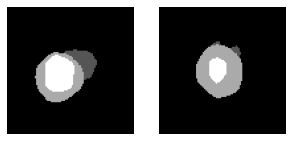

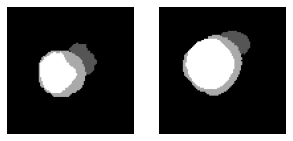

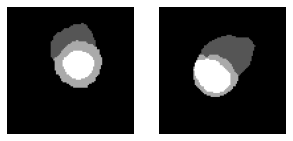

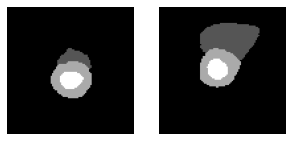

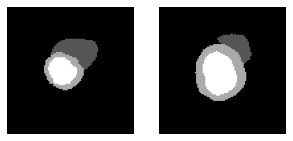

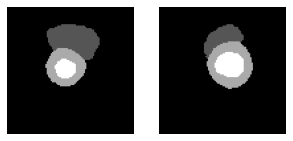

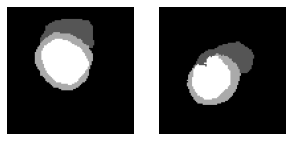

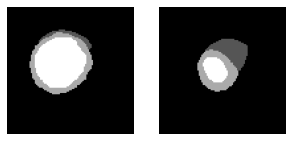

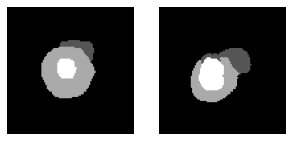

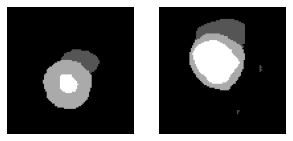

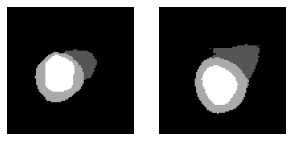

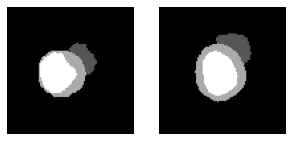

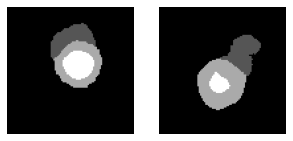

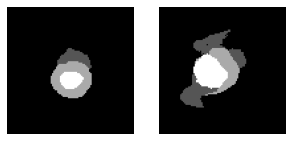

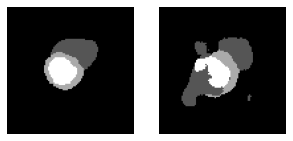

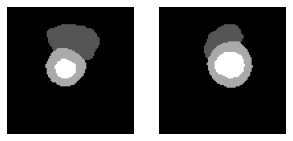

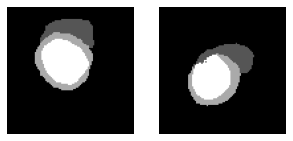

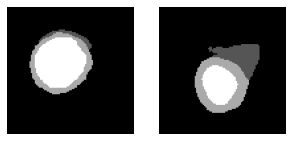

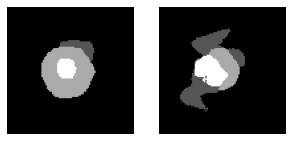

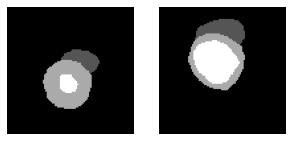

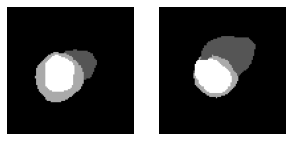

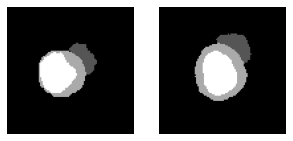

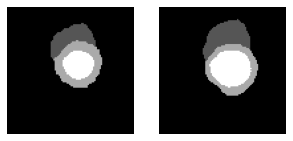

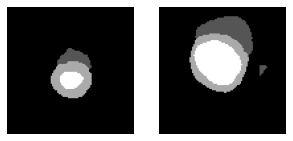

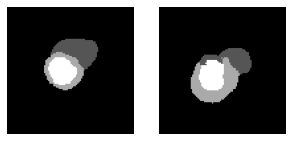

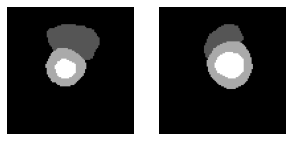

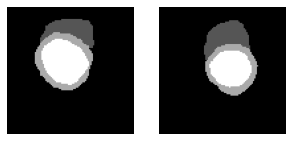

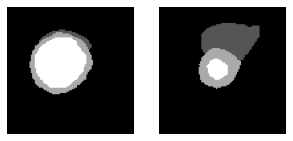

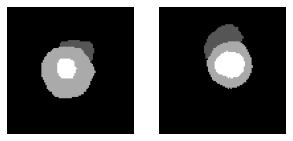

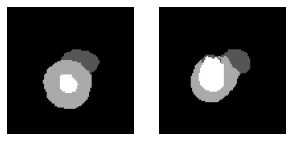

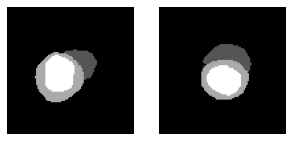

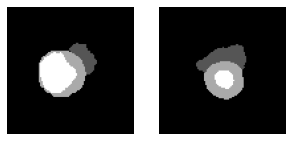

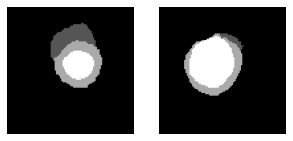

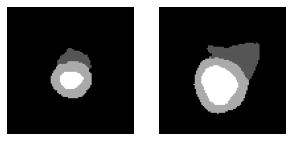

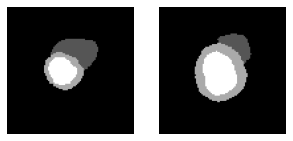

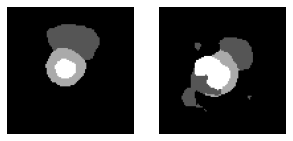

In [37]:
if __name__ == "__main__": 
#     validate(fcn, '199')
    for i in range(20):
        validate(fcn, 'exp')

# 3.3: Inference

In [ ]:
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms

<ipython-input-6-57e2c465ffdf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5,5))


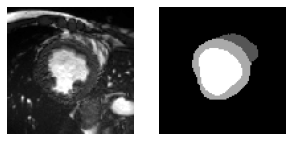

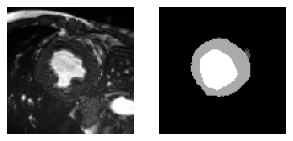

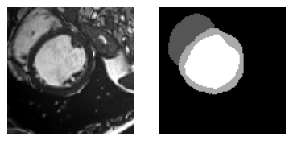

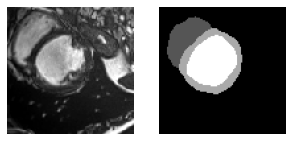

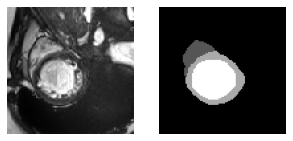

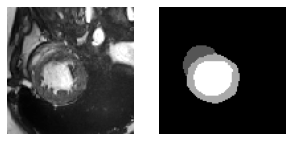

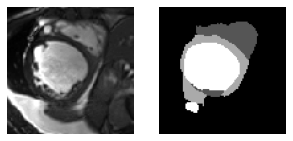

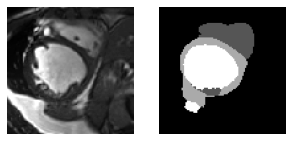

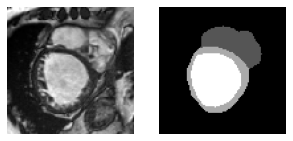

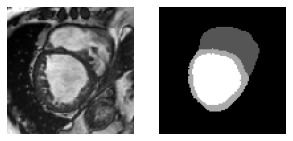

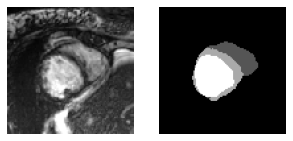

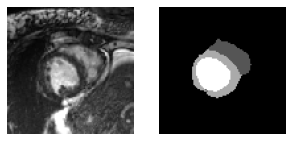

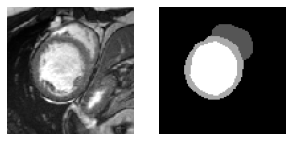

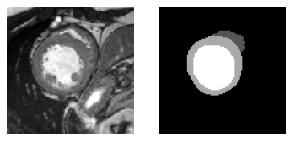

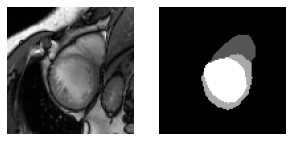

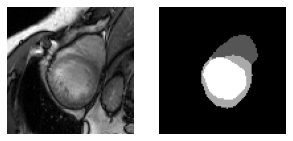

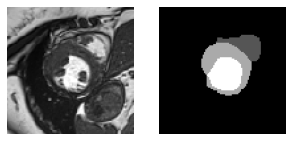

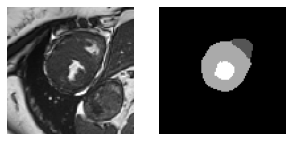

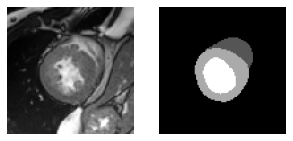

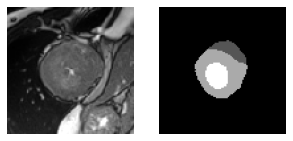

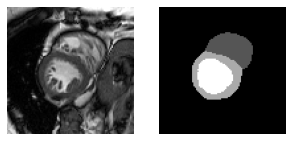

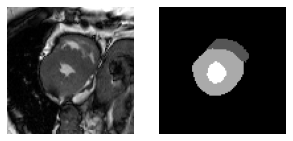

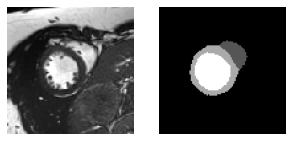

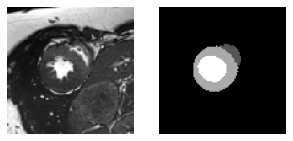

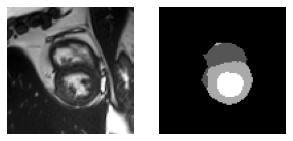

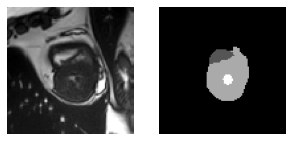

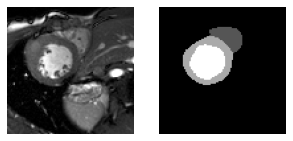

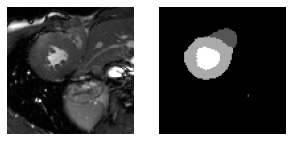

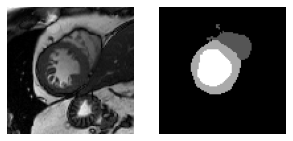

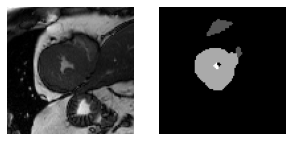

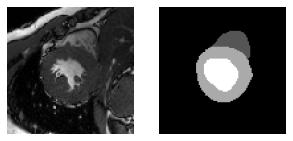

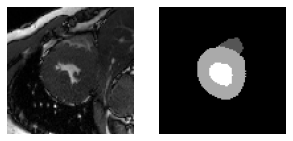

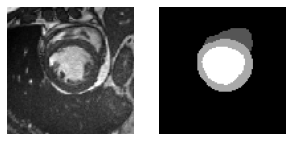

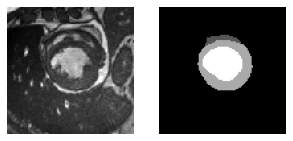

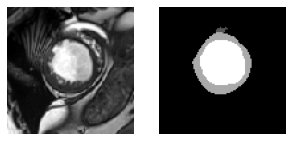

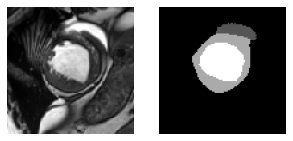

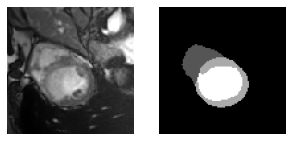

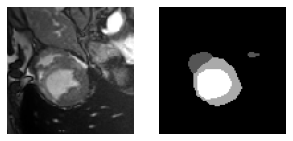

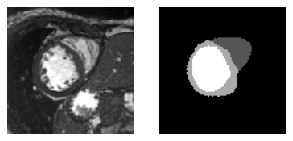

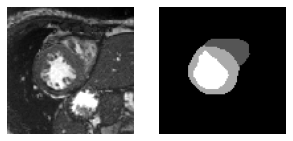

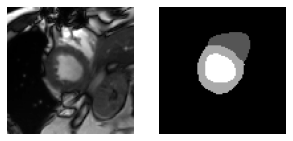

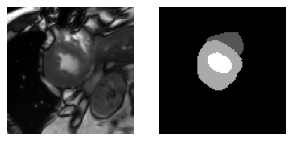

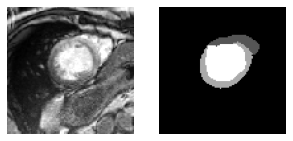

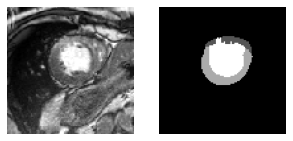

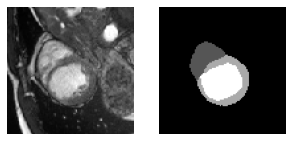

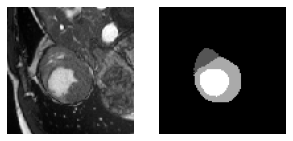

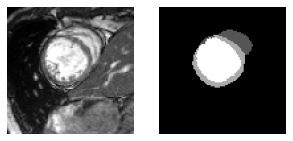

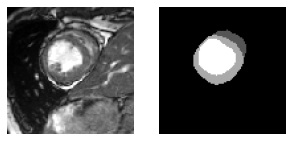

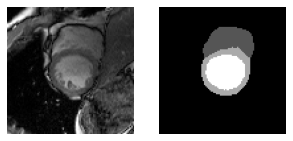

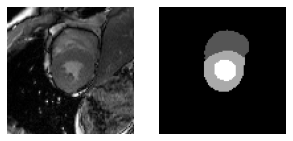

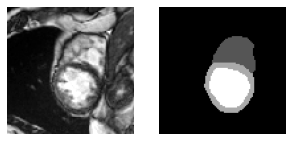

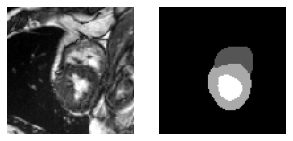

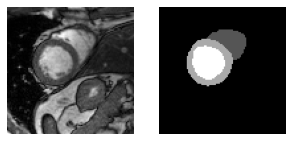

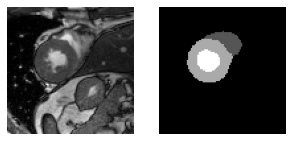

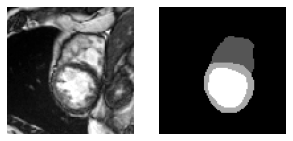

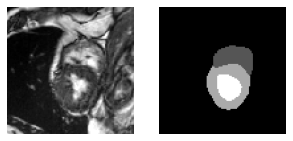

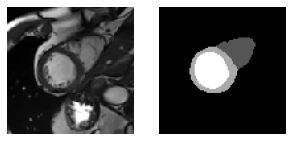

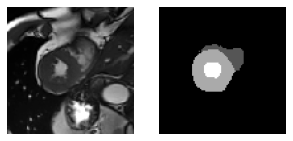

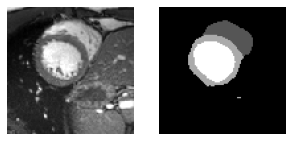

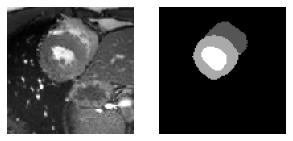

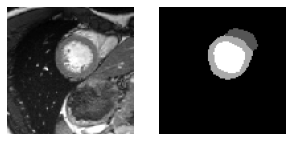

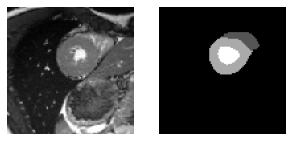

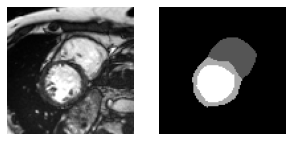

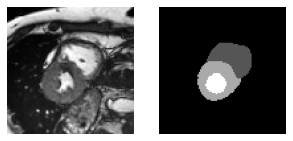

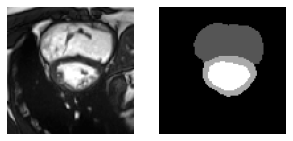

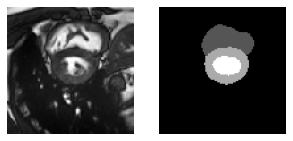

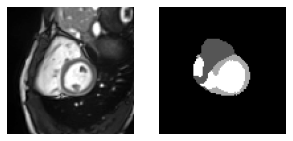

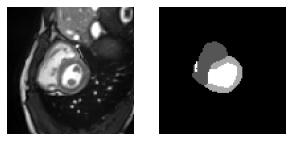

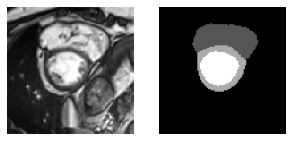

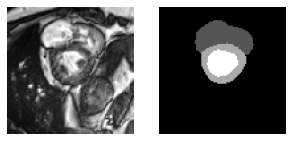

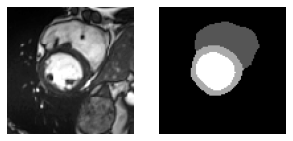

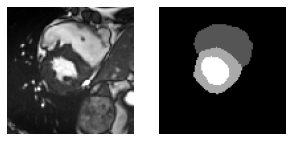

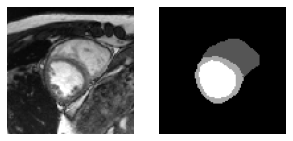

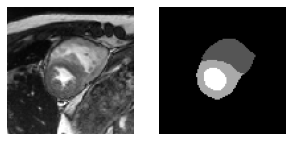

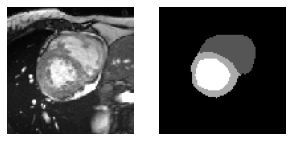

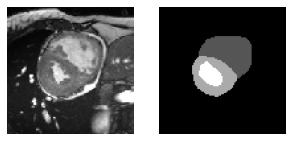

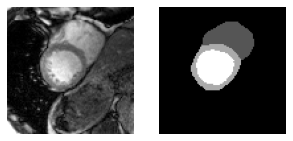

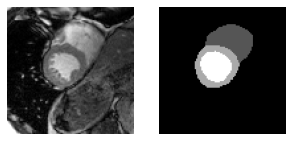

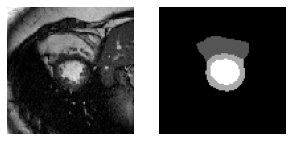

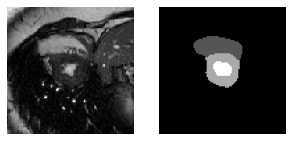

In [30]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 0
batch_size = 2
net = fcn.eval() 
net.load_state_dict(t.load('exp.pth',map_location='cpu')) # change the pretrained model path here
test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
conv_initial = nn.Conv2d(1, 3, 1)
data_save_path = './data/test/mask/'
index = 0

accuracy = 0

for iteration, sample in enumerate(test_data_loader):
    img_test = sample

    img_data = Variable(img_test.unsqueeze(1).to(device))
    out = net(img_data)
    out = F.log_softmax(out, dim=1)

    mask_image = torch.argmax(out.squeeze(), dim=1)
    
    for i in range(batch_size):
        image = cv2.imread(os.path.join(data_path,'image','cmr'+str(index+121+i)+'.png'), cv2.IMREAD_UNCHANGED)
        show_image_mask(image, mask_image[i], cmap='gray')
        cv2.imwrite(os.path.join(data_save_path, 'cmr'+str(index+121+i)+'_mask.png'), mask_image[i].detach().numpy())
    
    index += batch_size


# 4, Submission

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [ ]:
submission_converter(data_save_path, './data/test/submission_dir')